In [2]:
import numpy as np
import matplotlib.pyplot as plt
from aotools.functions import phaseFromZernikes


In [3]:
def get_disk_mask(shape, radius, center=None):
    """
    Generate a binary mask with value 1 inside a disk, 0 elsewhere
    :param shape: list of integer, shape of the returned array
    :radius: integer, radius of the disk
    :center: list of integers, position of the center
    :return: numpy array, the resulting binary mask
    """
    if not center:
        center = (shape[0] // 2, shape[1] // 2)
    X, Y = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]))
    mask = (Y - center[0]) ** 2 + (X - center[1]) ** 2 < radius**2
    return mask.astype(np.int)


def complex_mask_from_zernike_coeff(shape, radius, center, vec):
    """
    Generate a complex phase mask from a vector containting the coefficient of the first Zernike polynoms.
    :param DMD_resolution: list of integers, contains the resolution of the DMD, e.g. [1920,1200]
    :param: integer, radius of the illumination disk on the DMD
    :center: list of integers, contains the position of the center of the illumination disk
    :center: list of float, the coefficient of the first Zernike polynoms
    """
    # Generate a complex phase mask from the coefficients
    zern_mask = np.exp(1j * phaseFromZernikes(vec, 2 * radius))
    # We want the amplitude to be 0 outside the disk, we fist generate a binary disk mask
    amp_mask = get_disk_mask([2 * radius] * 2, radius)
    # put the Zernik mask at the right position and multiply by the disk mask
    mask = np.zeros(shape=shape, dtype=np.complex)
    mask[
        center[0] - radius : center[0] + radius, center[1] - radius : center[1] + radius
    ] = (zern_mask * amp_mask)
    return mask


def get_cost(img, mask_radius=8):
    res = img[0].shape
    mask_center = [res[0] // 2, res[1] // 2]
    X, Y = np.meshgrid(np.arange(res[0]), np.arange(res[1]))
    # We generate a mask representing the disk we want to intensity to be concentrated in
    mask = (X - mask_center[0]) ** 2 + (Y - mask_center[1]) ** 2 < mask_radius**2
    signal = np.sum((img) * mask) / np.sum(mask)
    noise = np.sum((img) * (1.0 - mask)) / np.sum(1.0 - mask)
    cost = signal / noise
    return cost


/tmp/ipykernel_757813/2282102113.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return mask.astype(np.int)
/tmp/ipykernel_757813/2282102113.py:29: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zero

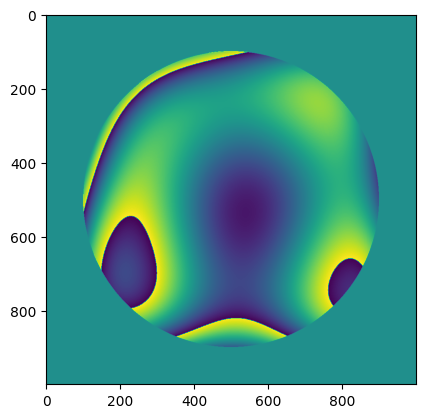

In [23]:
resolution = [1000, 1000]
center = [500, 500]
radius_illumination = 400
n_zernike_coeff = 11
n_zernike_coeff_to_0 = 3
zernike_max_amplitude = 1.
mask_input = get_disk_mask(resolution, 400, center)


zernike_coeff_aberrations = [0]*n_zernike_coeff_to_0+(zernike_max_amplitude*2*(np.random.rand(n_zernike_coeff)-.5)).tolist()
aberrations_mask = complex_mask_from_zernike_coeff(resolution, radius_illumination, center, zernike_coeff_aberrations)

plt.figure()
plt.imshow(np.angle(aberrations_mask))

/tmp/ipykernel_757813/2282102113.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return mask.astype(np.int)


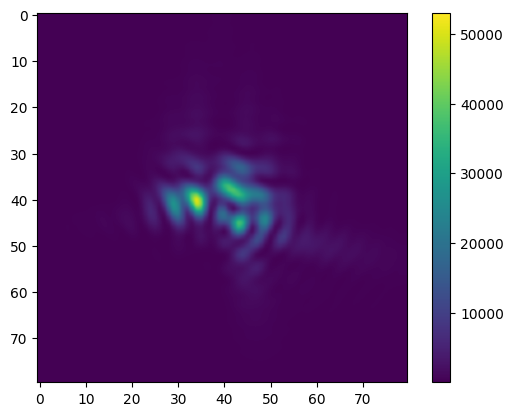

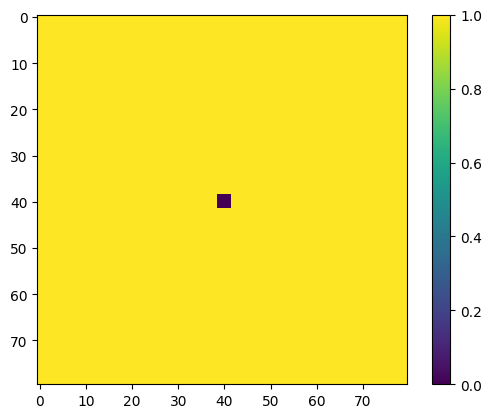

In [65]:
from scipy.signal import ZoomFFT

res_focus = 80
def ZoomFFT2D(A, m, fmax):
    n = A.shape[0]
    f = ZoomFFT(n, m = m, fn = [-fmax, fmax])
    FFT = f(A, axis = 0)
    FFT = f(FFT, axis = 1)
    return FFT

peak_center = np.zeros_like(aberrations_mask)
peak_center[center[0], center[1]] = 1
# ZoomFFT2D(A, fmax = 0.05, m = 100)
def focus(A):
    FT = ZoomFFT2D(A, fmax = 0.03, m = res_focus)
    FT = np.abs(FT)**2/np.sum(np.abs(A)**2)
    return FT

FTref = FFT(peak_center)
FFT2 = lambda A: FFT(A)

FT = focus(aberrations_mask)

plt.figure()
plt.imshow(np.abs(FT), interpolation='gaussian')
plt.colorbar()

mask_cost = get_disk_mask([res_focus]*2, 2)
inv_mask_cost = 1-mask_cost

/tmp/ipykernel_757813/2282102113.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return mask.astype(np.int)
/tmp/ipykernel_757813/2282102113.py:29: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zero

0.0660089530020869
0.06607109614936807
0.08152873960685483
0.10347634187607538
0.13813272359568368
0.1551086240790921
0.15951621375996333
0.19991822940165158
0.20317636958273055
0.21200256275107596
0.3306893313876572
0.3814661193409689
0.41500283848009123
0.41500283848009123
0.42782305042117186
0.42782305042117186
0.453394383338247
0.4636280070333131
0.5673471969110956
0.5711593103587775
0.6139114870852022


/tmp/ipykernel_757813/1496356928.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


0.6245208903488966
0.7684918583513541
0.8646950646946755
0.866256482037928
0.866256482037928
0.8882576249110573
0.8882576249110573
0.8882576249110573
0.9010142606845105
0.9010142606845105
0.9203574749978464
0.9203574749978464


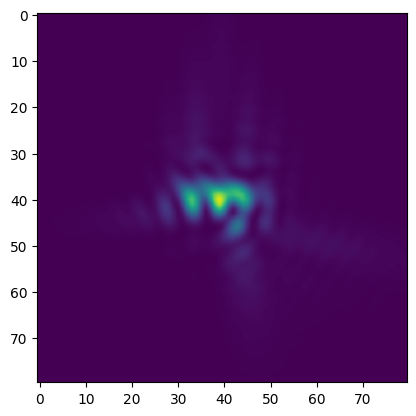

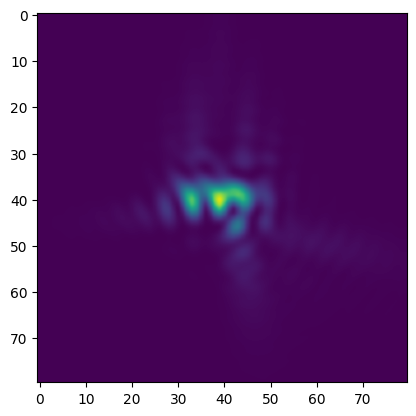

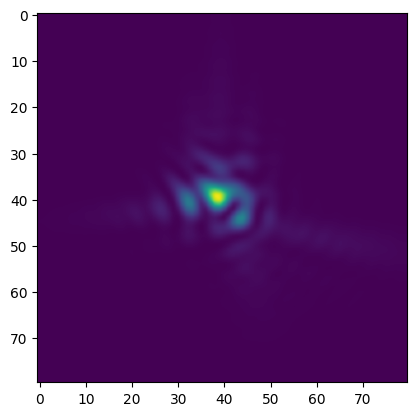

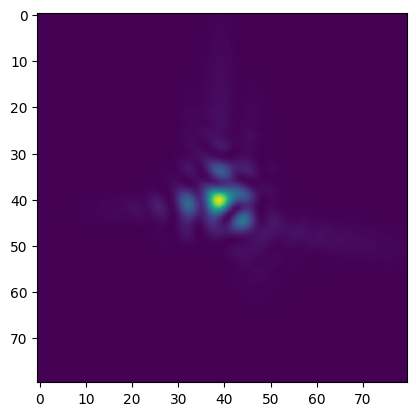

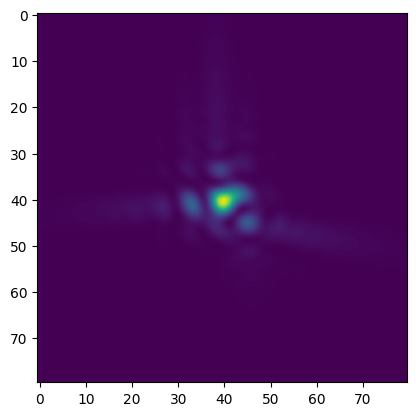

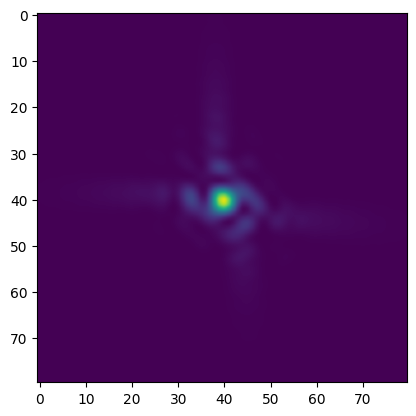

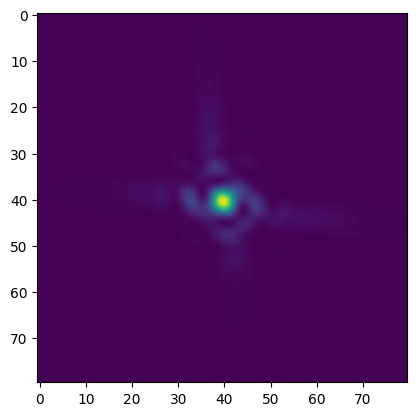

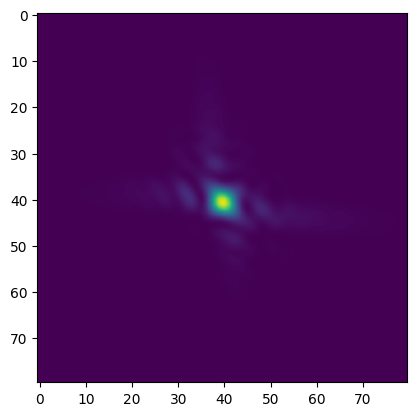

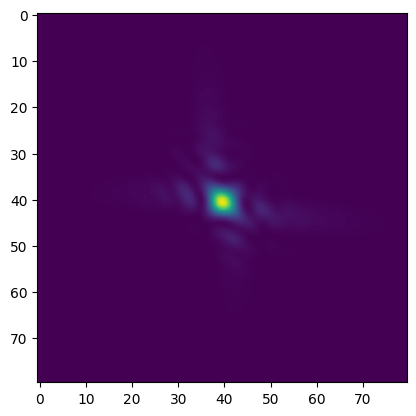

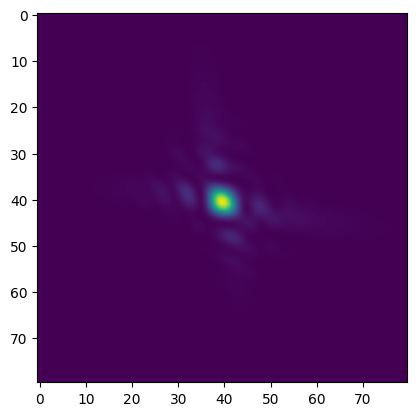

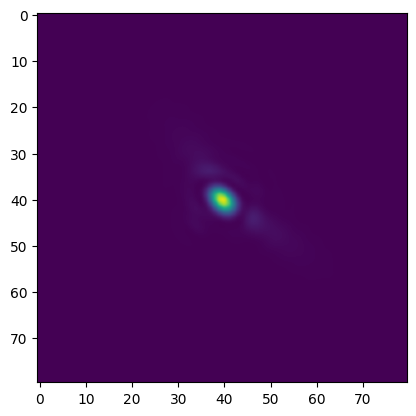

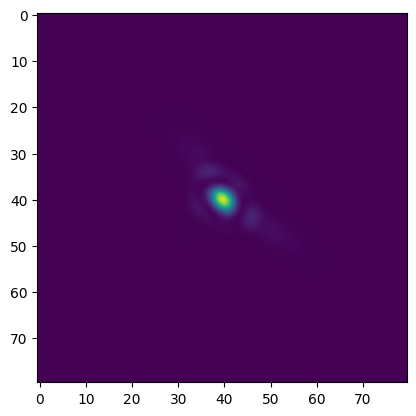

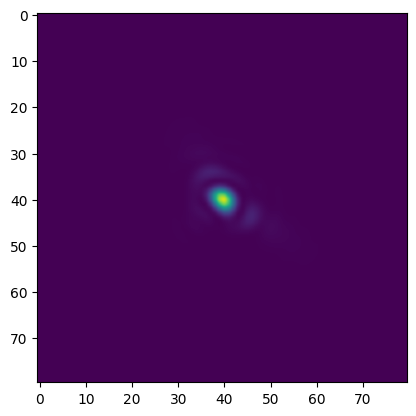

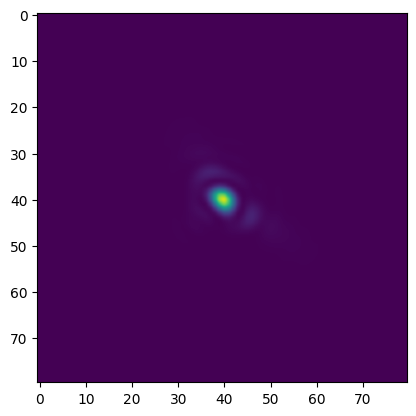

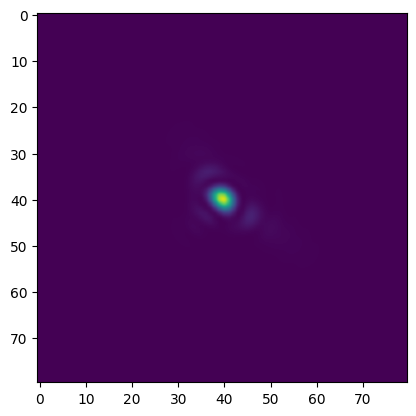

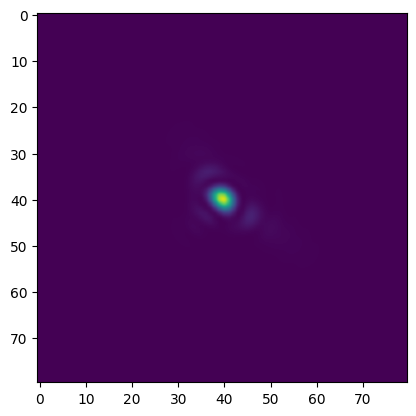

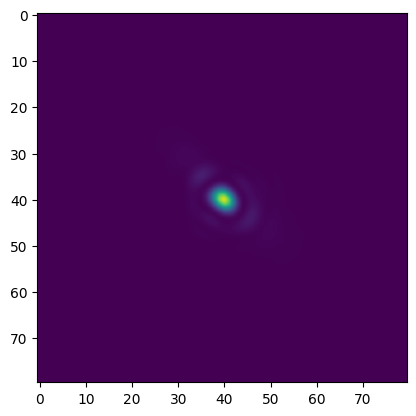

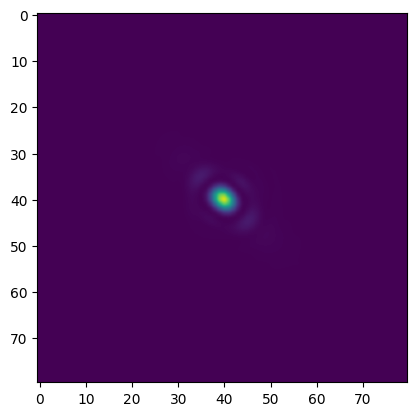

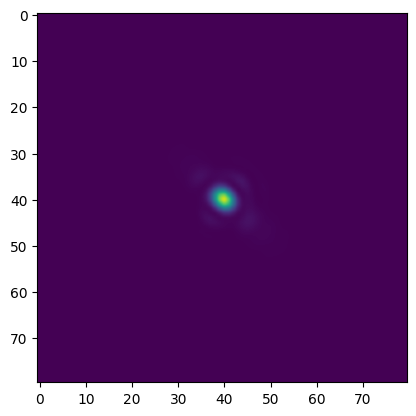

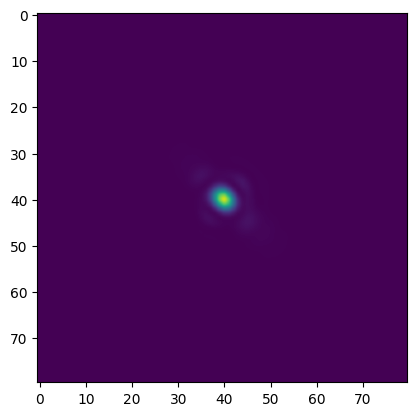

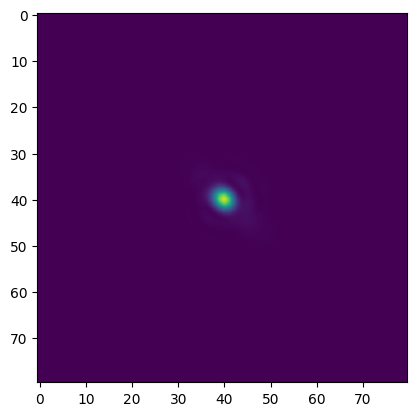

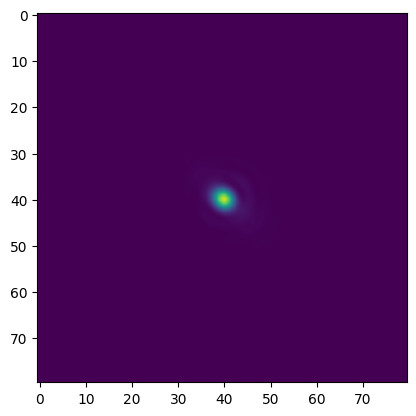

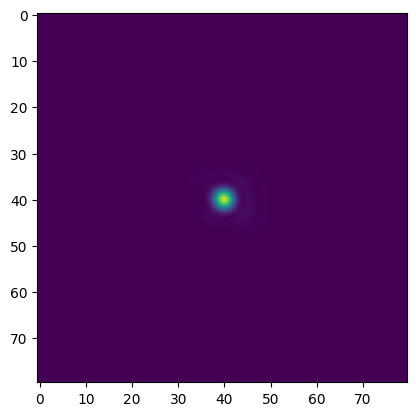

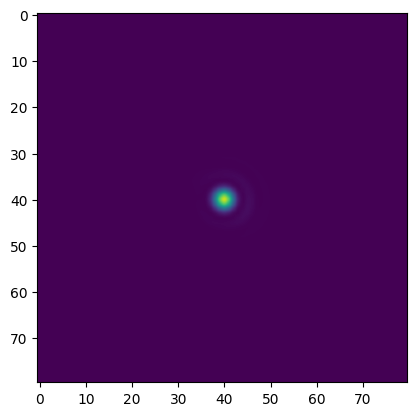

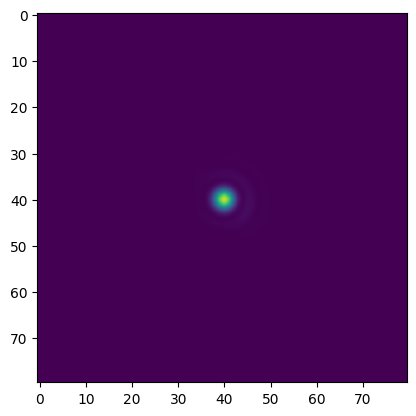

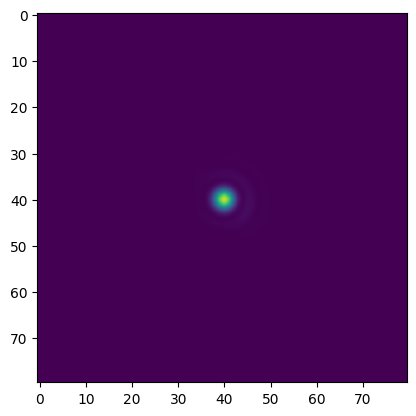

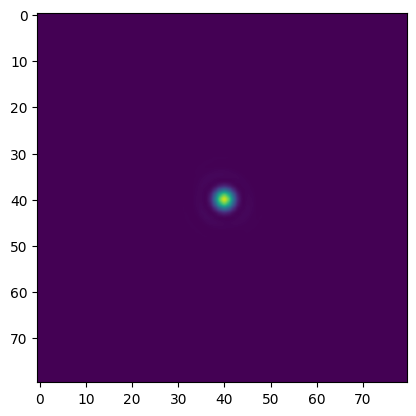

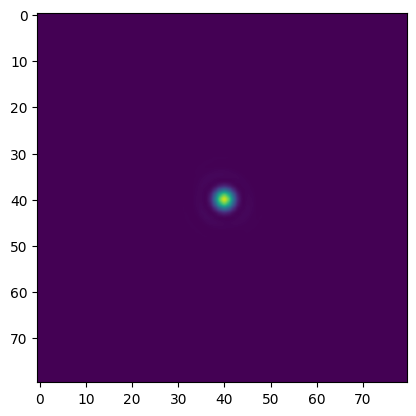

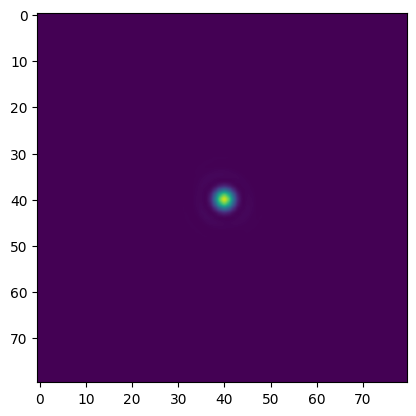

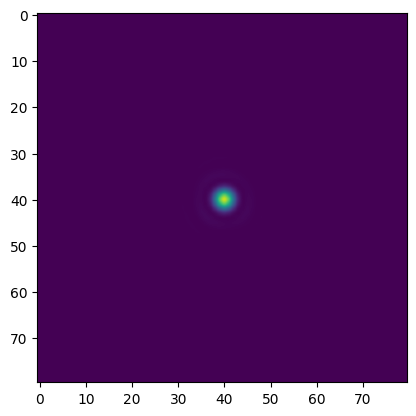

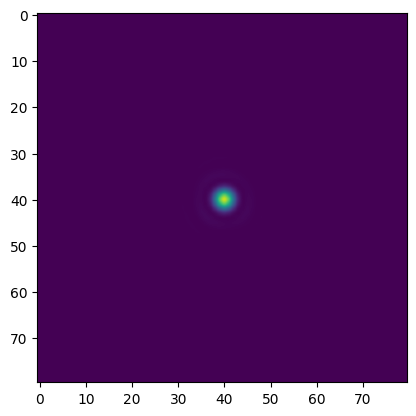

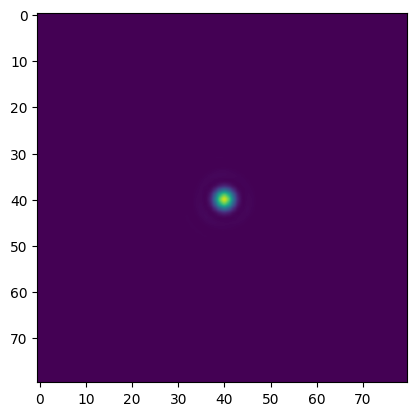

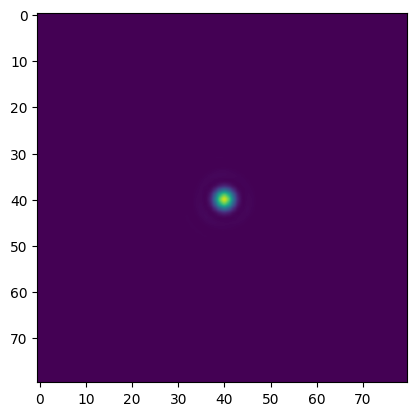

In [66]:
n_values_to_test = 30
values = np.linspace(-zernike_max_amplitude,zernike_max_amplitude,n_values_to_test)
vec_coeff = [0]*n_zernike_coeff
n_repeat = 3

def get_focus(vec):
    full_vec = [0]*n_zernike_coeff_to_0+vec
    phase_modulation = complex_mask_from_zernike_coeff(resolution, radius_illumination, center, full_vec)
    total_phase = phase_modulation*aberrations_mask
    img = focus(total_phase)
    return img

def get_cost(vec):
    img = get_focus(vec)
    return np.sum(img*mask_cost)/np.sum(inv_mask_cost*img)

for _ in range(n_repeat):
    for ind_zernike in range(n_zernike_coeff):
        best_cost = 0
        for coeff_value in values:
            vec_coeff[ind_zernike] = coeff_value
            cost = get_cost(vec_coeff)
            if cost>best_cost:
                best_cost = cost
                best_vec = vec_coeff.copy()
        vec_coeff = best_vec.copy()

/tmp/ipykernel_757813/2282102113.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return mask.astype(np.int)
/tmp/ipykernel_757813/2282102113.py:29: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zero

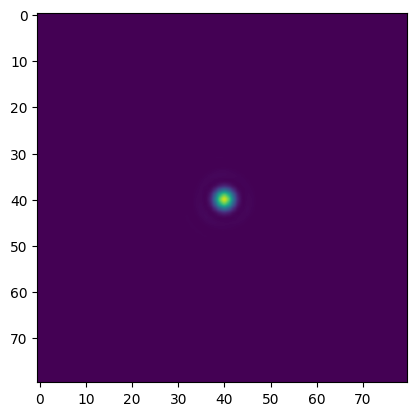

In [67]:
def get_focus(vec):
    full_vec = [0]*n_zernike_coeff_to_0+vec
    phase_modulation = complex_mask_from_zernike_coeff(resolution, radius_illumination, center, full_vec)
    total_phase = phase_modulation*aberrations_mask
    img = focus(total_phase)
    return img
I = get_focus(vec_coeff)
plt.figure()
plt.imshow(I, interpolation='gaussian')